In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from scipy.stats import ttest_ind
from scipy.signal import find_peaks
#supprimer les librairies mais garder les import de function 
from src.scripts.LIWC_statistical_analaysis import check_skewness, naive_analysis, statistical_analysis, liwc_multivariate_analysis
from src.data.dataloader import load_data, extend_properties, timestamp
from src.scripts.subreddits_activity import *
from src.scripts.temporal_analysis import plot_temporal
from src.scripts.conflict_definition import pair_conflict, visualize_results
from src.scripts.response_to_attack import attack_answer_analysis, test_significativity, attack_exchange_analysis
from src.scripts.conflict_definition import *
from src.scripts.t_test_deltaLIWC import *
#from tests.test_rf_deltaLIWC import *
from src.models.louvain import build_network, compute_louvain, count_communities
from src.utils.plot_utils import plot_num_cluster_time, plot_interactive
from src.data.dataloader import emb_loader
import pandas as pd
from src.models.kmeans_emb import normalize_emb, find_best_k, compute_kmeans_clusters, compute_tsne
from src.models.hdbscan_emb import compute_umap_2d, compute_hdbscan


In [2]:
#List of all LIWC and text characteristics needed to extend properties.
LIWC_list = [
    "LIWC_Funct", "LIWC_Pronoun", "LIWC_Ppron", "LIWC_I",
    "LIWC_We", "LIWC_You", "LIWC_SheHe", "LIWC_They", "LIWC_Ipron",
    "LIWC_Article", "LIWC_Verbs", "LIWC_AuxVb", "LIWC_Past", "LIWC_Present",
    "LIWC_Future", "LIWC_Adverbs", "LIWC_Prep", "LIWC_Conj", "LIWC_Negate",
    "LIWC_Quant", "LIWC_Numbers", "LIWC_Swear", "LIWC_Social", "LIWC_Family",
    "LIWC_Friends", "LIWC_Humans", "LIWC_Affect", "LIWC_Posemo", "LIWC_Negemo",
    "LIWC_Anx", "LIWC_Anger", "LIWC_Sad", "LIWC_CogMech", "LIWC_Insight",
    "LIWC_Cause", "LIWC_Discrep", "LIWC_Tentat", "LIWC_Certain", "LIWC_Inhib",
    "LIWC_Incl", "LIWC_Excl", "LIWC_Percept", "LIWC_See", "LIWC_Hear",
    "LIWC_Feel", "LIWC_Bio", "LIWC_Body", "LIWC_Health", "LIWC_Sexual",
    "LIWC_Ingest", "LIWC_Relativ", "LIWC_Motion", "LIWC_Space", "LIWC_Time",
    "LIWC_Work", "LIWC_Achiev", "LIWC_Leisure", "LIWC_Home", "LIWC_Money",
    "LIWC_Relig", "LIWC_Death", "LIWC_Assent", "LIWC_Dissent", "LIWC_Nonflu",
    "LIWC_Filler"
]

text_features=["num_chars","num_chars_no_space","frac_alpha","frac_digits","frac_upper","frac_space","frac_special",
"num_words","num_unique_words","num_long_words","avg_word_len","num_unique_stopwords","frac_stopwords",
"num_sentences","num_long_sentences","avg_chars_per_sentence","avg_words_per_sentence","automated_readability",
"vader_pos","vader_neg","vader_compound"] 

properties_name = text_features + LIWC_list

#This function will open and clean the data.
df_title, df_body = load_data()  

In [3]:
#This function will extend the properties from the original dataset to a new one to access easily the column.
df_title = extend_properties(df_title, properties_name)
df_body = extend_properties(df_body, properties_name)

#This function will transform the TIMESTAMP of the original data and extend it to have access to different timestamps.
df_title=timestamp(df_title)
df_body=timestamp(df_body)

In [4]:
subreddits, X = emb_loader(df_body)
X_norm = normalize_emb(X)
# 2D projection for visualization
X_umap2D = compute_umap_2d(X_norm)
X_tsne = compute_tsne(X_norm)

/home/charlotteW/.conda/envs/ada-gnn/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
# Louvain for the entire dataset (example with body)
df_body_pos = df_body[df_body['LINK_SENTIMENT'] == 1]
G_pos = build_network(df_body_pos)
partition_pos = compute_louvain(G_pos, use_weight = False)
count_communities(partition_pos)

543

In [6]:
subreddits, X = emb_loader(df_body)
X_norm = normalize_emb(X)
# 2D projection for visualization
X_umap2D = compute_umap_2d(X_norm)
X_tsne = compute_tsne(X_norm)

/home/charlotteW/.conda/envs/ada-gnn/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
# Louvain for the entire dataset (example with body)
G_all = build_network(df_body)
partition_all = compute_louvain(G_all, use_weight = False)
count_communities(partition_all)

556

In [9]:
import community as community_louvain

# 1. Calculer la partition AVEC poids
Q_w = community_louvain.modularity(partition_pos, G_pos.to_undirected())
print(Q_w)
# 2. Calculer la partition SANS poids

Q_unweighted = community_louvain.modularity(partition_all, G_all.to_undirected()) # Pas de paramètre 'weight' ici
print(Q_unweighted)

0.5223120540752427
0.5098026300242037


In [10]:
import networkx as nx

# Calculer la modularité de ta partition Louvain
# partition_fine est ton dictionnaire {node: cluster_id}
# Il faut convertir en liste d'ensembles pour nx
communities_list = [set() for _ in range(max(partition_all.values()) + 1)]
for node, c_id in partition_all.items():
    communities_list[c_id].add(node)
# Filtrer les sets vides si les IDs ne sont pas continus
communities_list = [c for c in communities_list if len(c) > 0]

modularity = nx.community.modularity(G_all, communities_list, weight='weight_louvain')
print(f"Modularité : {modularity:.4f}")

Modularité : 0.5279


In [12]:
# # Case A : UMAP puis HDBSCAN
# labels_a, sil_a, n_clusters_a = compute_hdbscan(X_norm, use_umap=True, n_components_umap=50, min_cluster_size = 5)
# # Case B : HDBSCAN direct
# labels_b, sil_b, n_clusters_b = compute_hdbscan(X_norm, use_umap=False, n_components_umap = 300, min_cluster_size = 5)

# print(f"[A] UMAP->HDBSCAN : clusters={n_clusters_a}, silhouette={sil_a}")
# print(f"[B] HDBSCAN direct : clusters={n_clusters_b}, silhouette={sil_b}")

In [14]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
labels_louvain = np.array([partition_all[node] for node in subreddits])
def compare_clusterings(labels1, labels2, name1, name2):
    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)
    print(f"\nComparing {name1} vs {name2}:")
    print(f"  ARI = {ari:.4f}")
    print(f"  NMI = {nmi:.4f}")

# Exemples

# compare_clusterings(labels_a, labels_louvain, "HDBSCAN", "Louvain")
labels_louvain_all = np.array([partition_all[node] for node in partition_pos])
labels_louvain_pos = np.array([partition_pos[node] for node in partition_pos])
compare_clusterings(labels_louvain_all, labels_louvain_pos, "louvain_pos", "louvain_all")
# Convert Louvain partition dict to label array



Comparing louvain_pos vs louvain_all:
  ARI = 0.5769
  NMI = 0.6980


In [15]:
import numpy as np
import networkx as nx
from sklearn.preprocessing import normalize
import random
random.seed(42)
# On crée un dictionnaire pour retrouver instantanément le vecteur d'un subreddit
# subreddits est ta liste de noms, X_norm tes vecteurs
node_to_emb = dict(zip(subreddits, X_norm))

# --- 3. Calcul des poids des arêtes ---
print("Calcul des poids des arêtes (Similarité Sémantique)...")

edges_updated = 0
missing_nodes = 0

# Note: On ne crée pas de nouveaux liens, on renforce ou affaiblit ceux existants.
for u, v in G_all.edges():
    # Vérifie si u et v ont bien un embedding associé
    if u in node_to_emb and v in node_to_emb:
        vec_u = node_to_emb[u]
        vec_v = node_to_emb[v]
        
        # Calcul ultra-rapide grâce à la pré-normalisation
        sim_score = np.dot(vec_u, vec_v)
        
        # Nettoyage : On s'assure que c'est entre 0 et 1
        # (Parfois les embeddings opposés donnent du négatif, on peut choisir de mettre 0)
        weight = max(0.0, float(sim_score))
        
        # On assigne ce poids à l'arête
        G_all[u][v]['weight'] = weight
        edges_updated += 1
    else:
        # Cas où un nœud du graphe n'a pas d'embedding dans X
        # On met un poids faible ou neutre (ex: 0 ou 0.1)
        G_all[u][v]['weight'] = 0.0
        missing_nodes += 1

print(f"Terminé. {edges_updated} liens pondérés. {missing_nodes} liens avec données manquantes.")

# --- 4. Louvain "Haute Résolution" ---
# C'est ici qu'on force les clusters à être "mieux définis" et plus petits.

# resolution > 1.0 -> Plus de petits clusters (Ce que tu veux)
# resolution < 1.0 -> Moins de gros clusters
RESOLUTION = 3

print(f"Exécution de Louvain (Resolution={RESOLUTION})...")
communities = nx.community.louvain_communities(
    G_all, 
    weight='weight',   # Important : Utiliser les poids calculés
    resolution=RESOLUTION
)

print(f"Nombre de communautés trouvées : {len(communities)}")

# Optionnel : Convertir en format dictionnaire {node: cluster_id}
partition_fine = {node: i for i, com in enumerate(communities) for node in com}
count_communities(partition_fine)

Calcul des poids des arêtes (Similarité Sémantique)...
Terminé. 116215 liens pondérés. 21606 liens avec données manquantes.
Exécution de Louvain (Resolution=3)...
Nombre de communautés trouvées : 14784


14784

Total des clusters : 14784
Clusters ignorés (taille 1) : 14566
Clusters affichés (taille > 1) : 218
Taille moyenne (filtrée) : 97.29


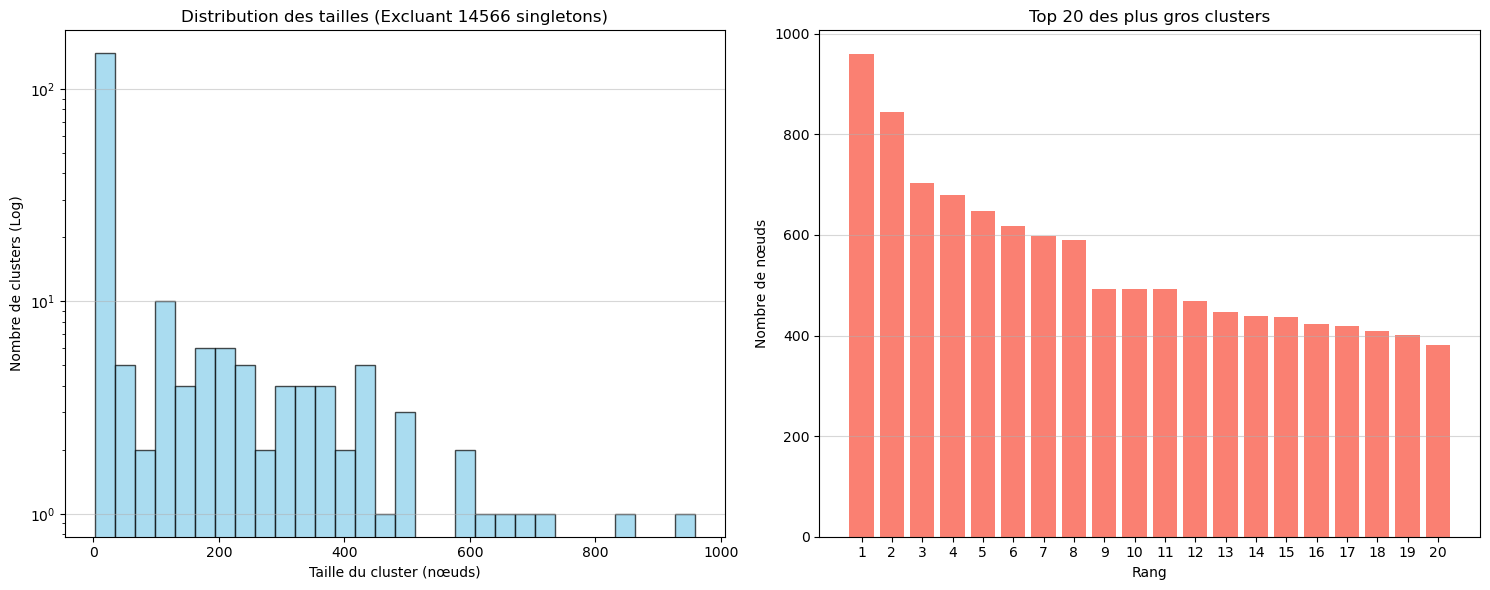

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que 'communities' est ta liste obtenue par Louvain
# communities = nx.community.louvain_communities(...)

# 1. Calcul de toutes les tailles
all_cluster_sizes = [len(c) for c in communities]
all_cluster_sizes.sort(reverse=True)

# 2. FILTRAGE : On sépare les clusters de taille 1 des autres
# On ne garde que ceux qui ont au moins 2 subreddits
filtered_sizes = [s for s in all_cluster_sizes if s > 1]
singletons_count = len(all_cluster_sizes) - len(filtered_sizes)

# --- STATISTIQUES ---
print(f"Total des clusters : {len(all_cluster_sizes)}")
print(f"Clusters ignorés (taille 1) : {singletons_count}")
print(f"Clusters affichés (taille > 1) : {len(filtered_sizes)}")

if len(filtered_sizes) > 0:
    print(f"Taille moyenne (filtrée) : {np.mean(filtered_sizes):.2f}")
else:
    print("Attention : Tous les clusters sont de taille 1 !")

# --- VISUALISATION ---
plt.figure(figsize=(15, 6))

# GRAPHIQUE 1 : Histogramme (SANS les tailles 1)
plt.subplot(1, 2, 1)
if len(filtered_sizes) > 0:
    plt.hist(filtered_sizes, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.yscale('log') # On garde l'échelle log
    plt.title(f'Distribution des tailles (Excluant {singletons_count} singletons)')
    plt.xlabel('Taille du cluster (nœuds)')
    plt.ylabel('Nombre de clusters (Log)')
    plt.grid(axis='y', alpha=0.5)
else:
    plt.text(0.5, 0.5, "Aucun cluster > 1", ha='center')

# GRAPHIQUE 2 : Top 20 (Basé sur la liste complète, car les plus gros sont > 1)
k = 20
if len(all_cluster_sizes) < k: k = len(all_cluster_sizes)

plt.subplot(1, 2, 2)
plt.bar(range(k), all_cluster_sizes[:k], color='salmon')
plt.title(f'Top {k} des plus gros clusters')
plt.xlabel('Rang')
plt.ylabel('Nombre de nœuds')
# On ajoute les labels 1st, 2nd, etc.
plt.xticks(range(k), [str(i+1) for i in range(k)])
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# import networkx as nx
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import silhouette_score

# def evaluate_resolution_impact(graph, X_embeddings, node_names, resolutions):
#     """
#     Teste différentes résolutions pour Louvain et calcule les métriques.
    
#     Args:
#         graph: Le graphe NetworkX (g_all) avec les poids 'weight' déjà calculés.
#         X_embeddings: La matrice numpy des embeddings (alignée avec node_names).
#         node_names: Liste des noms de nœuds dans l'ordre de X_embeddings.
#         resolutions: Liste des valeurs de résolution à tester.
#     """
    
#     metrics = {
#         'resolution': [],
#         'num_clusters': [],
#         'modularity': [],
#         'silhouette': []
#     }
    
#     print(f"Début de l'analyse sur {len(resolutions)} résolutions...\n")
    
#     # Création d'un map index -> nom pour rapidité
#     node_to_idx = {name: i for i, name in enumerate(node_names)}
    
#     for res in resolutions:
#         print(f"Testing resolution = {res}...", end=" ")
        
#         # 1. Exécuter Louvain
#         # seed=42 assure que le résultat est reproductible
#         communities = nx.community.louvain_communities(graph, weight='weight', resolution=res, seed=42)
        
#         # 2. Préparer les labels pour Silhouette Score
#         # On doit créer un array de labels aligné avec X_embeddings
#         labels = np.full(len(node_names), -1) # -1 par défaut
        
#         # On remplit les labels
#         for cluster_id, community_set in enumerate(communities):
#             for node in community_set:
#                 if node in node_to_idx:
#                     idx = node_to_idx[node]
#                     labels[idx] = cluster_id
        
#         # Filtrage: On ne calcule le score que sur les nœuds qui sont dans le graphe
#         # (Au cas où X a plus de nœuds que g_all)
#         mask = labels != -1
#         if np.sum(mask) < 2: # Sécurité
#             print("Pas assez de clusters.")
#             continue
            
#         # 3. Calcul des Métriques
        
#         # A. Modularité (Structure)
#         try:
#             mod = nx.community.modularity(graph, communities, weight='weight')
#         except:
#             mod = 0
            
#         # B. Silhouette (Sémantique)
#         # Attention: C'est lourd si N > 20k. On peut utiliser sample_size=10000 pour accélérer.
#         sil = silhouette_score(X_embeddings[mask], labels[mask], metric='cosine')
        
#         # Stockage
#         metrics['resolution'].append(res)
#         metrics['num_clusters'].append(len(communities))
#         metrics['modularity'].append(mod)
#         metrics['silhouette'].append(sil)
        
#         print(f"Clusters: {len(communities)}, Mod: {mod:.3f}, Sil: {sil:.3f}")

#     return metrics

# # --- UTILISATION ---

# # Définir la plage de résolutions à tester
# # On teste autour de 3.0 puisque c'est ton choix actuel
# resolutions_to_test = [1.0, 2.0, 3.0, 4.0, 5.0, 10, 20, 30, 50]

# # Lancer l'analyse (Assure-toi que g_all a bien les poids calculés !)
# results = evaluate_resolution_impact(G_pos, X_norm, subreddits, resolutions_to_test)

# # --- VISUALISATION ---

# fig, ax1 = plt.subplots(figsize=(10, 6))

# color = 'tab:red'
# ax1.set_xlabel('Résolution (gamma)')
# ax1.set_ylabel('Silhouette Score (Sémantique)', color=color)
# ax1.plot(results['resolution'], results['silhouette'], color=color, marker='o', label='Silhouette (Embeddings)')
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.grid(True, alpha=0.3)

# ax2 = ax1.twinx()  # Axe partagé
# color = 'tab:blue'
# ax2.set_ylabel('Nombre de Clusters', color=color)
# ax2.plot(results['resolution'], results['num_clusters'], color=color, marker='s', linestyle='--', label='Nb Clusters')
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Compromis : Cohérence Sémantique vs Finesse du Clustering')
# plt.show()

# # Graphique séparé pour la Modularité
# plt.figure(figsize=(10, 4))
# plt.plot(results['resolution'], results['modularity'], marker='o', color='green')
# plt.title("Modularité (Structurelle) en fonction de la Résolution")
# plt.xlabel("Résolution")
# plt.ylabel("Modularité Q")
# plt.grid(True)
# plt.show()

Début de l'analyse sur 9 résolutions...

Testing resolution = 1.0... Clusters: 14279, Mod: 0.638, Sil: -0.693
Testing resolution = 2.0... Clusters: 14296, Mod: 0.628, Sil: -0.679
Testing resolution = 3.0... 

KeyboardInterrupt: 

In [17]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

def get_cluster_leaders(graph, partition, embeddings_dict=None, top_k=5):
    """
    Affiche les subreddits les plus représentatifs de chaque cluster.
    
    Args:
        graph: Le graphe NetworkX (g_all)
        partition: Dictionnaire {node: cluster_id}
        embeddings_dict: (Optionnel) Dict {node: vector}. Si fourni, calcule aussi le leader sémantique.
        top_k: Nombre de noms à afficher par cluster.
    """
    
    # 1. Regrouper les nœuds par cluster
    clusters = {}
    for node, c_id in partition.items():
        if c_id not in clusters: clusters[c_id] = []
        clusters[c_id].append(node)
    
    # On trie les clusters par taille (pour afficher les gros en premier)
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)
    
    print(f"--- Analyse des Thèmes (Top {len(sorted_clusters)} clusters) ---\n")
    
    for c_id, nodes in sorted_clusters:
        # On ignore les trop petits clusters pour l'affichage
        if len(nodes) < 5: continue
            
        # --- METHODE 1 : LEADER STRUCTUREL (Le plus connecté dans le groupe) ---
        # On regarde le degré, mais uniquement vers les autres membres du MEME cluster
        subgraph = graph.subgraph(nodes)
        
        # On trie les nœuds par degré (pondéré si possible) dans ce sous-graphe
        # degree return (node, degree_value)
        sorted_by_degree = sorted(subgraph.degree(weight='weight'), key=lambda x: x[1], reverse=True)
        top_structural = [n for n, d in sorted_by_degree[:top_k]]
        
        # --- METHODE 2 : LEADER SÉMANTIQUE (Le centre géométrique) ---
        top_semantic = []
        if embeddings_dict is not None:
            # On récupère les vecteurs des nœuds de ce cluster
            cluster_vectors = []
            valid_nodes = []
            for node in nodes:
                if node in embeddings_dict:
                    cluster_vectors.append(embeddings_dict[node])
                    valid_nodes.append(node)
            
            if cluster_vectors:
                # 1. Calculer le vecteur moyen (Centroïde)
                centroid = np.mean(cluster_vectors, axis=0).reshape(1, -1)
                
                # 2. Trouver les nœuds les plus proches de ce centroïde
                # On compare le centroïde à tous les nœuds du cluster
                sims = cosine_similarity(centroid, cluster_vectors)[0]
                
                # On récupère les indices des plus proches
                best_indices = sims.argsort()[-top_k:][::-1]
                top_semantic = [valid_nodes[i] for i in best_indices]

        # --- AFFICHAGE ---
        print(f"🔷 Cluster {c_id} (Taille: {len(nodes)})")
        print(f"   👑 Hubs (Centralité): {', '.join(top_structural)}")
        if top_semantic:
            print(f"   🧠 Core (Sémantique): {', '.join(top_semantic)}")
        print("-" * 40)

# --- UTILISATION ---

# Supposons que tu aies :
# 1. g_all : ton graphe
# 2. partition_fine : ton résultat Louvain {node: id}
# 3. node_to_emb : ton dictionnaire {node: embedding} créé plus tôt

get_cluster_leaders(G_all, partition_fine, embeddings_dict=node_to_emb, top_k=7)

--- Analyse des Thèmes (Top 14784 clusters) ---

🔷 Cluster 57 (Taille: 959)
   👑 Hubs (Centralité): ps4, gaming, destinythegame, games, gamedev, xboxone, fallout
   🧠 Core (Sémantique): mgsphantompain, moddergearsolid, skyrim_mods, witcher3mods, deathstranding, forzahorizon3, fallout4
----------------------------------------
🔷 Cluster 51 (Taille: 845)
   👑 Hubs (Centralité): tipofmypenis, dirtypenpals, gonewildstories, dirtyr4r, gonewildaudio, r4r, nsfw411
   🧠 Core (Sémantique): cuckquean, bimbofication, doppelbangher, toobig, sarah_xxx, cuckoldstories, tipsdonttouch
----------------------------------------
🔷 Cluster 26 (Taille: 704)
   👑 Hubs (Centralité): outoftheloop, copypasta, karmacourt, subredditoftheday, justunsubbed, hailcorporate, bestof2015
   🧠 Core (Sémantique): unnecessaryquotes, fullscorpion, oopsdidntmeanto, thecatdimension, nothingeverhappens, garlicbreadmemes, badtaxidermy
----------------------------------------
🔷 Cluster 152 (Taille: 679)
   👑 Hubs (Centralité): mu

In [18]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

def export_cluster_leaders(graph, partition, embeddings_dict=None, top_k=5, file_name="cluster_labels.csv"):
    """
    Génère un fichier CSV contenant les leaders de chaque cluster pour labélisation.
    
    Args:
        graph: Le graphe NetworkX (G_all)
        partition: Dictionnaire {node: cluster_id}
        embeddings_dict: (Optionnel) Dict {node: vector}
        top_k: Nombre de leaders à sauvegarder par cluster
        file_name: Nom du fichier de sortie
    
    Returns:
        DataFrame contenant les infos des clusters.
    """
    
    print("🚀 Démarrage de l'analyse des clusters...")

    # 1. Regrouper les nœuds par cluster
    clusters = {}
    for node, c_id in partition.items():
        if c_id not in clusters: clusters[c_id] = []
        clusters[c_id].append(node)
    
    # On trie les clusters par taille (du plus grand au plus petit)
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)
    
    results = []

    for c_id, nodes in sorted_clusters:
        # Condition demandée : on ignore les clusters de taille 0 ou 1
        if len(nodes) <= 1: 
            continue
            
        # --- 1. LEADER STRUCTUREL (Hub) ---
        # Le nœud qui a le plus de liens VERS les autres membres du cluster
        subgraph = graph.subgraph(nodes)
        # On utilise le degré pondéré 'weight' si dispo, sinon degré simple
        sorted_by_degree = sorted(subgraph.degree(weight='weight'), key=lambda x: x[1], reverse=True)
        
        # On récupère les top_k noms
        top_hubs = [n for n, d in sorted_by_degree[:top_k]]
        primary_hub = top_hubs[0] if top_hubs else "Unknown"
        
        # --- 2. LEADER SÉMANTIQUE (Core) ---
        top_cores = []
        primary_core = None
        
        if embeddings_dict is not None:
            cluster_vectors = []
            valid_nodes = []
            for node in nodes:
                if node in embeddings_dict:
                    cluster_vectors.append(embeddings_dict[node])
                    valid_nodes.append(node)
            
            if cluster_vectors:
                # Calcul du centroïde (la moyenne de tous les vecteurs du cluster)
                centroid = np.mean(cluster_vectors, axis=0).reshape(1, -1)
                # Similarité de tous les nœuds avec ce centroïde
                sims = cosine_similarity(centroid, cluster_vectors)[0]
                # Indices des plus proches
                best_indices = sims.argsort()[-top_k:][::-1]
                top_cores = [valid_nodes[i] for i in best_indices]
                primary_core = top_cores[0] if top_cores else None

        # --- 3. CHOIX DU LABEL AUTOMATIQUE ---
        # Par défaut, on prend le Hub (souvent le subreddit le plus populaire du groupe)
        # Mais si tu préfères le sens sémantique, tu peux inverser l'ordre
        auto_label = primary_hub 
        
        # Enregistrement des données
        results.append({
            'Cluster_ID': c_id,
            'Size': len(nodes),
            'Auto_Label': auto_label,         # Le label qu'on utilisera par défaut
            'Top_Hubs': ", ".join(top_hubs),  # Liste pour vérification humaine
            'Top_Cores': ", ".join(top_cores) if top_cores else "", # Liste sémantique
            'Primary_Core': primary_core      # Le meilleur représentant sémantique
        })

    # Création du DataFrame
    df_clusters = pd.DataFrame(results)
    
    # Sauvegarde en CSV
    df_clusters.to_csv(file_name, index=False)
    
    print(f"✅ Analyse terminée. {len(df_clusters)} clusters traités.")
    print(f"📂 Fichier sauvegardé sous : {file_name}")
    print("\n--- Aperçu des 5 plus gros clusters ---")
    print(df_clusters[['Cluster_ID', 'Size', 'Auto_Label', 'Top_Cores']].head())
    
    return df_clusters

# --- UTILISATION ---

# Utilise tes variables existantes ici
df_labels = export_cluster_leaders(
    graph=G_all, 
    partition=partition_fine, 
    embeddings_dict=node_to_emb, # Mets None si tu n'as pas d'embeddings
    top_k=5,
    file_name="cluster_definitions.csv"
)

🚀 Démarrage de l'analyse des clusters...
✅ Analyse terminée. 218 clusters traités.
📂 Fichier sauvegardé sous : cluster_definitions.csv

--- Aperçu des 5 plus gros clusters ---
   Cluster_ID  Size    Auto_Label  \
0          57   959           ps4   
1          51   845  tipofmypenis   
2          26   704  outoftheloop   
3         152   679         music   
4         150   648          iama   

                                           Top_Cores  
0  mgsphantompain, moddergearsolid, skyrim_mods, ...  
1  cuckquean, bimbofication, doppelbangher, toobi...  
2  unnecessaryquotes, fullscorpion, oopsdidntmean...  
3  musicinthemaking, macdemarco, vinyljerk, neutr...  
4  scorpion, bloodandicecream, fanedits, oitnb, x...  


In [19]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

def export_cluster_leaders(graph, partition, embeddings_dict=None, top_k=5, file_name="cluster_definitions.csv"):
    """
    Génère un fichier CSV contenant les leaders et la liste complète des membres de chaque cluster.
    """
    
    print("🚀 Démarrage de l'analyse des clusters...")

    # 1. Regrouper les nœuds par cluster
    clusters = {}
    for node, c_id in partition.items():
        if c_id not in clusters: clusters[c_id] = []
        clusters[c_id].append(node)
    
    # Tri des clusters par taille
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)
    
    results = []

    for c_id, nodes in sorted_clusters:
        # On ignore les clusters trop petits (<= 1)
        if len(nodes) <= 1: 
            continue
            
        # --- 1. LEADER STRUCTUREL (Hub) ---
        subgraph = graph.subgraph(nodes)
        sorted_by_degree = sorted(subgraph.degree(weight='weight'), key=lambda x: x[1], reverse=True)
        top_hubs = [n for n, d in sorted_by_degree[:top_k]]
        primary_hub = top_hubs[0] if top_hubs else "Unknown"
        
        # --- 2. LEADER SÉMANTIQUE (Core) ---
        top_cores = []
        primary_core = None
        
        if embeddings_dict is not None:
            cluster_vectors = []
            valid_nodes = []
            for node in nodes:
                if node in embeddings_dict:
                    cluster_vectors.append(embeddings_dict[node])
                    valid_nodes.append(node)
            
            if cluster_vectors:
                centroid = np.mean(cluster_vectors, axis=0).reshape(1, -1)
                sims = cosine_similarity(centroid, cluster_vectors)[0]
                best_indices = sims.argsort()[-top_k:][::-1]
                top_cores = [valid_nodes[i] for i in best_indices]
                primary_core = top_cores[0] if top_cores else None

        # --- 3. STOCKAGE DES RÉSULTATS ---
        
        results.append({
            'Cluster_ID': c_id,
            'Size': len(nodes),
            'Auto_Label': primary_hub,        
            'Top_Hubs': ", ".join(top_hubs), 
            'Top_Cores': ", ".join(top_cores) if top_cores else "",
            # C'EST ICI QUE J'AI AJOUTÉ LA LISTE COMPLÈTE :
            'All_Members': ", ".join(nodes)   
        })

    # Création du DataFrame
    df_clusters = pd.DataFrame(results)
    
    # Sauvegarde en CSV
    df_clusters.to_csv(file_name, index=False)
    
    print(f"✅ Analyse terminée. {len(df_clusters)} clusters traités.")
    print(f"📂 Fichier sauvegardé sous : {file_name}")
    
    return df_clusters

# --- UTILISATION ---

df_labels = export_cluster_leaders(
    graph=G_all, 
    partition=partition_fine, 
    embeddings_dict=node_to_emb, 
    top_k=5, 
    file_name="cluster_full_data_2.csv"
)

# Pour vérifier visuellement la nouvelle colonne :
print(df_labels[['Cluster_ID', 'Size', 'All_Members']].head())

🚀 Démarrage de l'analyse des clusters...
✅ Analyse terminée. 218 clusters traités.
📂 Fichier sauvegardé sous : cluster_full_data_2.csv
   Cluster_ID  Size                                        All_Members
0          57   959  gtaonlinehax, 12in12, dyinglight, proceduralge...
1          51   845  futadomworld, yiffbondage, notgayporn, r4rwi, ...
2          26   704  beetlejuicing, funnycharts, fastfoodreview, aw...
3         152   679  deathgrips, creativity, psychedelicrock, bassn...
4         150   648  henna, kagw, misc, starwarsgames, the100, lets...


In [20]:
# 1. Créer un dictionnaire de mapping : {Cluster_ID : Label}
label_map = df_labels.set_index('Cluster_ID')['Auto_Label'].to_dict()

# 2. Si tu as un DataFrame 'df_nodes' avec une colonne 'cluster'
# df_nodes['Cluster_Name'] = df_nodes['cluster'].map(label_map)

# 3. Ou si tu veux juste récupérer le label d'un cluster spécifique (ex: cluster 3)
nom_du_cluster_3 = label_map.get(3, "Cluster Inconnu")
print(f"Le cluster 3 est le thème : {nom_du_cluster_3}")

Le cluster 3 est le thème : Cluster Inconnu


--- CAMP hottiesfortrump (Top 10) ---
['hottiesfortrump', 'merylrearsolid', 'the_donald', 'mr_trump', 'pyrocynical', 'dankmemes', 'tucker_carlson', 'mgsvideathstranding', 'askthe_donald', 'onepiececirclejerk', 'dank_meme', 'china2034', 'warmachine', 'filthyfrank', 'worldofnintendo', 'cringeanarchy', 'monstercatcringe', 'thecasualplates', 'prequelmemes', 'kumocrew']

--- CAMP hillaryforamerica (Top 10) ---
['thisisnotagame', 'hillaryforamerica', 'bluemidterm2018', 'martinomalley', 'panelshow', 'enoughhillhate', 'badsocialscience', 'impeach_trump', 'democrats', 'antitrumpalliance', 'transit', 'racism', 'progressive', 'longevity', 'renewableenergy', 'wilmingtonde', 'wisconsin', 'enoughlibertarianspam', 'enough_sanders_spam', 'urbanplanning']


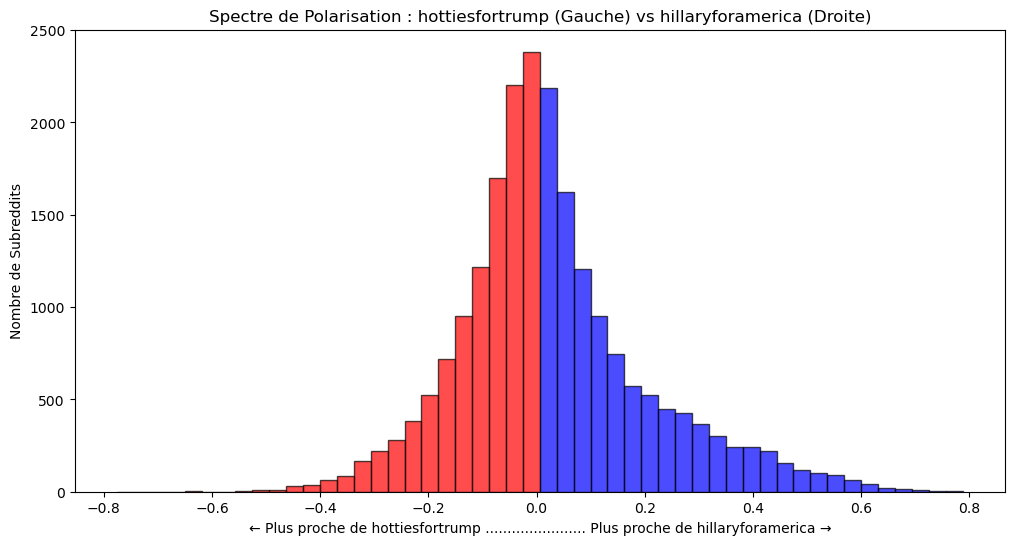

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def analyze_polarization(node_to_emb, node_list, seed_a, seed_b):
    """
    Analyse la polarisation entre deux pôles définis par des seeds.
    
    Args:
        seed_a: Nom d'un subreddit représentatif du camp A (ex: 'The_Donald')
        seed_b: Nom d'un subreddit représentatif du camp B (ex: 'HillaryClinton')
    """
    
    if seed_a not in node_to_emb or seed_b not in node_to_emb:
        print(f"Erreur : {seed_a} ou {seed_b} n'a pas d'embedding.")
        return

    # 1. Définir l'Axe de Polarisation
    # Vecteur A -> B
    vec_a = node_to_emb[seed_a]
    vec_b = node_to_emb[seed_b]
    
    axis_vector = vec_b - vec_a
    
    # On calcule la projection de chaque nœud sur cet axe
    # Score < 0 : Proche de A (Trump)
    # Score > 0 : Proche de B (Hillary)
    # Score ~ 0 : Neutre / Orthogonal
    
    projections = []
    names = []
    
    for node in node_list:
        if node in node_to_emb:
            vec = node_to_emb[node]
            # Projection scalaire
            proj = np.dot(vec, axis_vector)
            projections.append(proj)
            names.append(node)
            
    projections = np.array(projections)
    
    # 2. Visualisation (Histogramme de la Polarisation)
    plt.figure(figsize=(12, 6))
    
    # On colore les barres selon le camp
    n, bins, patches = plt.hist(projections, bins=50, alpha=0.7, edgecolor='black')
    
    for i in range(len(patches)):
        if bins[i] < 0:
            patches[i].set_facecolor('red')   # Camp A (ex: Républicain)
        else:
            patches[i].set_facecolor('blue')  # Camp B (ex: Démocrate)
            
    plt.title(f"Spectre de Polarisation : {seed_a} (Gauche) vs {seed_b} (Droite)")
    plt.xlabel(f"← Plus proche de {seed_a} ....................... Plus proche de {seed_b} →")
    plt.ylabel("Nombre de Subreddits")
    
    # Afficher les extrêmes
    sorted_indices = np.argsort(projections)
    
    print(f"--- CAMP {seed_a} (Top 10) ---")
    print([names[i] for i in sorted_indices[:20]])
    
    print(f"\n--- CAMP {seed_b} (Top 10) ---")
    print([names[i] for i in sorted_indices[-20:][::-1]])

    plt.show()

# --- UTILISATION ---
# Remplace par les vrais noms de subreddits présents dans tes données
# Assure-toi que ces noms existent dans 'subreddits'
analyze_polarization(node_to_emb, subreddits, 'hottiesfortrump', 'hillaryforamerica') 
# Ou autre exemple : 'cat' vs 'dog', 'apple' vs 'android'

Analyse sur le sous-graphe politique (493 noeuds)...
--- CAMP donald_trump (Top 10) ---
['donald_trump', 'nrxn', 'hottiesfortrump', 'electionpolls', 'the_wilders', 'the_farage', 'the_europe', 'unfilter', 'mr_trump', 'le_pen', 'the_donald', 'pedogate', 'the_frauke', 'hillarymeltdown', 'metalporn', 'btfo', 'womenfortrump', 'the_donaldunleashed', 'nationalsocialism', 'new_right']

--- CAMP hillaryclinton (Top 10) ---
['enoughtrumpspam', 'enough_sanders_spam', 'enoughhillhate', 'bluemidterm2018', 'thisisnotagame', 'hillaryclinton', 'enoughsandersspam', 'hillaryforamerica', 'martinomalley', 'impeach_trump', 'anybodybutbernie', 'badpolitics', 'antitrumpalliance', 'drumpf', 'enoughlibertarianspam', 'democrats', 'indivisibleguide', 'shitthe_donaldsays', 'esist', 'badsocialscience']


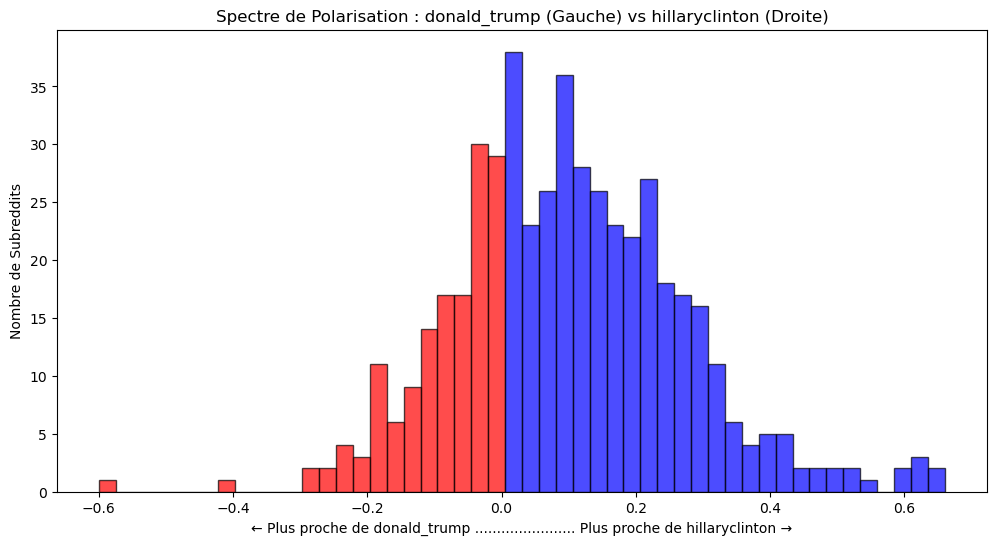

In [22]:
# 1. Identifier l'ID du cluster politique
# On cherche où est 'The_Donald'
id_cluster_politique = partition_fine['politics']

# 2. Récupérer tous les membres de ce cluster
nodes_politiques = [node for node, cid in partition_fine.items() if cid == id_cluster_politique]

print(f"Analyse sur le sous-graphe politique ({len(nodes_politiques)} noeuds)...")

# 3. Relancer l'analyse de polarisation UNIQUEMENT sur ces nœuds
analyze_polarization(node_to_emb, nodes_politiques, 'donald_trump', 'hillaryclinton')

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ==============================================================================
# 1. PRÉPARATION DES DONNÉES (Alignement Graphe <-> Embeddings)
# ==============================================================================

def align_data(G, embedding_dict):
    """
    Version robuste avec debugging des noms.
    """
    # 1. Vérification des formats de clés
    sample_graph_node = list(G.nodes())[0]
    sample_emb_key = list(embedding_dict.keys())[0]
    
    print(f"--- DIAGNOSTIC ---")
    print(f"Exemple clé Graphe : '{sample_graph_node}' (Type: {type(sample_graph_node)})")
    print(f"Exemple clé Embeddings : '{sample_emb_key}' (Type: {type(sample_emb_key)})")
    
    # 2. Intersection
    valid_nodes = [n for n in G.nodes() if n in embedding_dict]
    intersection_count = len(valid_nodes)
    
    print(f"Nœuds Graphe : {len(G.nodes())}")
    print(f"Nœuds Embeddings : {len(embedding_dict)}")
    print(f"INTERSECTION TROUVÉE : {intersection_count}")
    
    if intersection_count == 0:
        print("\n⚠️ ATTENTION : Aucune correspondance ! Essayons de nettoyer les noms...")
        # Tentative de fix courant (ex: retirer 'r/' ou mettre en minuscule)
        # Ceci est juste pour tester, adaptez selon vos données
        g_nodes_clean = set([str(n).replace('r/', '').lower() for n in G.nodes()])
        emb_keys_clean = set([str(k).replace('r/', '').lower() for k in embedding_dict.keys()])
        intersection_clean = g_nodes_clean.intersection(emb_keys_clean)
        print(f"Intersection après nettoyage basique (minuscule/sans prefixe) : {len(intersection_clean)}")
        
        raise ValueError("Arrêt : L'intersection est vide. Vérifiez les noms dans vos deux sources.")

    # 3. Création des données
    G_sub = G.subgraph(valid_nodes).copy().to_undirected()
    x_features = []
    node_mapping = {} 
    
    for i, node_name in enumerate(G_sub.nodes()):
        emb = embedding_dict[node_name]
        x_features.append(emb)
        node_mapping[i] = node_name

    # Conversion sécurisée en array numpy 2D
    x_np = np.array(x_features)
    
    # Si les embeddings sont des scalaires (juste des nombres), on force la 2D
    if x_np.ndim == 1:
        x_np = x_np.reshape(-1, 1)
        
    x = torch.tensor(x_np, dtype=torch.float)
    
    data = from_networkx(G_sub)
    data.x = x
    
    return data, node_mapping

# --- EXÉCUTION DE LA PRÉPARATION ---
# On suppose que G_pos et node_to_emb existent déjà dans votre environnement
data, id_to_name = align_data(G_pos, node_to_emb)

# ==============================================================================
# 2. DÉFINITION DU MODÈLE GNN (VGAE)
# ==============================================================================

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Couche 1 : Compresse et mélange avec les voisins
        # Dimension cachée arbitraire (ici 2x la sortie), souvent 32 ou 64
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        
        # Couches de sortie pour la moyenne (mu) et la variance (logstd)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

# Paramètres
input_dim = data.x.shape[1]   # Taille de vos embeddings initiaux
latent_dim = 64            # Taille du vecteur final compressé (Smart embedding)

# Initialisation
encoder = GCNEncoder(input_dim, latent_dim)
model = VGAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# ==============================================================================
# 3. ENTRAÎNEMENT (Apprentissage de la fusion Structure + Sémantique)
# ==============================================================================

print("\nDébut de l'entraînement du GNN...")
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    
    # Encodage : calcul de Z (l'espace latent)
    z = model.encode(data.x, data.edge_index)
    
    # Loss de reconstruction : est-ce que Z permet de deviner les liens du graphe ?
    loss = model.recon_loss(z, data.edge_index)
    # Regularisation KL : pour garder l'espace bien distribué
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")
# ==============================================================================
# 4. CLUSTERING FINAL (HDBSCAN sur les "Smart Embeddings")
# ==============================================================================

import hdbscan
from sklearn.metrics import silhouette_score

model.eval()
with torch.no_grad():
    # On récupère les embeddings finaux optimisés par le GNN
    z = model.encode(data.x, data.edge_index)
    gnn_embeddings = z.numpy()

print("\nClustering avec HDBSCAN sur les embeddings GNN...")

# Paramètres HDBSCAN (à ajuster pour affiner vos clusters)
# min_cluster_size : La taille minimale d'un groupe pour être considéré comme un cluster.
# min_samples : Un point a besoin d'avoir ce nombre de voisins pour être considéré comme un point de cœur (densité).
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2, # Les communautés doivent avoir au moins 2 subreddits
    min_samples=1,
    gen_min_span_tree=True # Souvent conseillé pour la visualisation
)

# Application du clustering
clusters = clusterer.fit_predict(gnn_embeddings)

# Le nombre de clusters est déterminé automatiquement (exclut le bruit)
n_clusters_found = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_points = np.sum(clusters == -1)

print(f"Nombre de clusters trouvés (hors bruit) : {n_clusters_found}")
print(f"Nombre de points classés comme bruit (-1) : {n_noise_points}")

# NOTE : Le Silhouette Score est calculé ici SANS inclure le bruit (-1)
valid_indices = clusters != -1
if valid_indices.sum() > 1:
    sil_score = silhouette_score(gnn_embeddings[valid_indices], clusters[valid_indices])
    print(f"Score de Silhouette final (HDBSCAN, sans bruit) : {sil_score:.4f}")
else:
    sil_score = None
    print("Le score de Silhouette n'est pas calculable (trop peu de points valides).")


# ==============================================================================
# 5. RECONSTRUCTION DU RÉSULTAT
# ==============================================================================

# Dictionnaire final {Nom_Subreddit : ID_Cluster}
final_clusters_dict = {id_to_name[i]: cluster_id for i, cluster_id in enumerate(clusters)}

# Affichage d'un échantillon
print("\nExemples d'assignation :")
sample = list(final_clusters_dict.items())[:5]
for name, clust in sample:
    # Le cluster -1 signifie "Bruit" ou "Outlier"
    print(f"- {name} : Cluster {clust} {'(Bruit)' if clust == -1 else ''}")

--- DIAGNOSTIC ---
Exemple clé Graphe : 'leagueoflegends' (Type: <class 'str'>)
Exemple clé Embeddings : 'spiders' (Type: <class 'str'>)
Nœuds Graphe : 35010
Nœuds Embeddings : 21675
INTERSECTION TROUVÉE : 21374

Début de l'entraînement du GNN...
Epoch 000, Loss: 6.9740
Epoch 050, Loss: 0.9607
Epoch 100, Loss: 0.9022
Epoch 150, Loss: 0.8809

Clustering avec HDBSCAN sur les embeddings GNN...


/home/charlotteW/.conda/envs/ada-gnn/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/charlotteW/.conda/envs/ada-gnn/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Nombre de clusters trouvés (hors bruit) : 4423
Nombre de points classés comme bruit (-1) : 9264
Score de Silhouette final (HDBSCAN, sans bruit) : 0.2982

Exemples d'assignation :
- leagueoflegends : Cluster -1 (Bruit)
- teamredditteams : Cluster 4251 
- inlandempire : Cluster 1949 
- bikela : Cluster 2640 
- nfl : Cluster 23 


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import umap
import plotly.express as px
import plotly.graph_objects as go

# --- (Votre code de préparation des données, GNN, entraînement et clustering) ---
# Assurez-vous que les variables `gnn_embeddings`, `clusters`, `id_to_name` sont disponibles
# --- (Copiez/Collez votre code précédent jusqu'à la fin de la section 4) ---

# ==============================================================================
# 5. VISUALISATION INTERACTIVE AVEC UMAP et PLOTLY
# ==============================================================================

print("\nPréparation de la visualisation UMAP interactive...")

# 1. Réduction de dimension avec UMAP
# On utilise gnn_embeddings (les embeddings optimisés par le GNN)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42) # Paramètres UMAP à ajuster si besoin
embedding_2d = reducer.fit_transform(gnn_embeddings) 

# 2. Création d'un DataFrame pour Plotly
df_interactive = pd.DataFrame(embedding_2d, columns=['UMAP_X', 'UMAP_Y'])
df_interactive['Cluster'] = clusters.astype(str) # Convertir en string pour que Plotly les traite comme des catégories
df_interactive['Subreddit'] = [id_to_name[i] for i in range(len(clusters))]

# Ajout du score de silhouette pour référence
sil = silhouette_score(gnn_embeddings, clusters)
print(f"Score de Silhouette pour la visualisation : {sil:.4f}")

# 3. Création de la figure interactive avec Plotly
fig = px.scatter(
    df_interactive,
    x='UMAP_X',
    y='UMAP_Y',
    color='Cluster',
    hover_data=['Subreddit', 'Cluster'], # Infos affichées au survol
    title=f'Projection UMAP des Embeddings GNN par Cluster (Silhouette: {sil:.4f})',
    labels={'UMAP_X': 'UMAP Dimension 1', 'UMAP_Y': 'UMAP Dimension 2'},
    color_discrete_sequence=px.colors.qualitative.Dark24, # Pour plus de couleurs si > 10 clusters
    height=700
)

# Améliorations visuelles (optionnel)
fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    hovermode='closest',
    # Ajouter un peu de marge autour des points
    margin=dict(t=80, b=80, l=80, r=80)
)

# Sauvegarder en HTML (pour partager ou ouvrir dans un navigateur)
fig.write_html("gnn_umap_interactive_clusters.html")

# Afficher la figure interactive directement (nécessite un environnement compatible comme Jupyter, VS Code ou un navigateur)
fig.show()

print("\nVisualisation interactive générée et sauvegardée sous 'gnn_umap_interactive_clusters.html'.")
print("Ouvrez le fichier HTML dans votre navigateur web pour interagir avec la carte.")


Préparation de la visualisation UMAP interactive...


/home/charlotteW/.conda/envs/ada-gnn/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Score de Silhouette pour la visualisation : -0.1539



Visualisation interactive générée et sauvegardée sous 'gnn_umap_interactive_clusters.html'.
Ouvrez le fichier HTML dans votre navigateur web pour interagir avec la carte.


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import umap
import plotly.express as px
import plotly.graph_objects as go

# --- (Je suppose que votre code précédent pour charger les données, entrainer le GNN 
#      et générer `gnn_embeddings`, `clusters`, `id_to_name` est ici) ---

# ==============================================================================
# 5. VISUALISATION INTERACTIVE AVEC UMAP et PLOTLY
# ==============================================================================

print("\nPréparation de la visualisation UMAP interactive...")

# 1. Réduction de dimension avec UMAP
# On utilise gnn_embeddings (les embeddings optimisés par le GNN)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(gnn_embeddings) 

# 2. Création d'un DataFrame pour Plotly
df_interactive = pd.DataFrame(embedding_2d, columns=['UMAP_X', 'UMAP_Y'])
df_interactive['Cluster'] = clusters.astype(str) # Convertir en string pour Plotly
df_interactive['Subreddit'] = [id_to_name[i] for i in range(len(clusters))]

# Ajout du score de silhouette pour référence
sil = silhouette_score(gnn_embeddings, clusters)
print(f"Score de Silhouette pour la visualisation : {sil:.4f}")

# 3. Création de la figure interactive avec Plotly
fig = px.scatter(
    df_interactive,
    x='UMAP_X',
    y='UMAP_Y',
    color='Cluster',
    hover_data=['Subreddit', 'Cluster'], # Infos affichées au survol
    title=f'Projection UMAP des Embeddings GNN par Cluster (Silhouette: {sil:.4f})',
    labels={'UMAP_X': 'UMAP Dimension 1', 'UMAP_Y': 'UMAP Dimension 2'},
    color_discrete_sequence=px.colors.qualitative.Dark24, 
    height=700
)

# Améliorations visuelles
fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    hovermode='closest',
    margin=dict(t=80, b=80, l=80, r=80)
)

# Sauvegarde et affichage
fig.write_html("gnn_umap_interactive_clusters.html")
# fig.show() # Décommenter si vous êtes dans Jupyter

print("\nVisualisation interactive générée et sauvegardée sous 'gnn_umap_interactive_clusters.html'.")

# ==============================================================================
# 6. ANALYSE ET AFFICHAGE DES GRANDS CLUSTERS
# ==============================================================================

print("\n" + "="*50)
print("ANALYSE DES CLUSTERS PRINCIPAUX")
print("="*50)

# 1. Compter la taille de chaque cluster
cluster_counts = df_interactive['Cluster'].value_counts()

# 2. Définir ce qu'est un "grand" cluster (ici le top 5, ou ceux > X éléments)
# On va prendre les 5 plus grands pour l'exemple
top_n_clusters = 5
largest_clusters = cluster_counts.head(top_n_clusters)

print(f"Affichage des {top_n_clusters} plus grands clusters (sur {len(cluster_counts)} total):\n")

for cluster_id, size in largest_clusters.items():
    # Récupérer tous les subreddits de ce cluster
    subreddits_in_cluster = df_interactive[df_interactive['Cluster'] == cluster_id]['Subreddit'].tolist()
    
    print(f"--- Cluster {cluster_id} (Taille : {size} subreddits) ---")
    
    # Afficher un échantillon (les 15 premiers pour ne pas spammer la console)
    sample_size = min(15, len(subreddits_in_cluster))
    sample = subreddits_in_cluster[:sample_size]
    
    # Formatage pour l'affichage (liste séparée par des virgules)
    print(f"Exemples : {', '.join(sample)}")
    
    if len(subreddits_in_cluster) > sample_size:
        print(f"... et {len(subreddits_in_cluster) - sample_size} autres.")
    print("") # Ligne vide pour la lisibilité